# Imports

In [1]:
import pandas as pd

from utils import build_rule_configurator, compute_confusion_matrix, compute_scores

# Data loading

In [2]:
train_df = pd.read_csv("../data/train.csv").fillna("")
test_df = pd.read_csv("../data/test.csv").fillna("")

# Feature creation

In order to improve our model, we need to define some more interesting set of rules.

What kind of rules could be relevant for identifying duplicates ? Here are some possible rules:

- An observation (pair of questions) is a duplicate if **the two questions have approximately the same number of words**
- An observation is a duplicate if **the two questions have approximately the same number of question marks**
- An observation is a duplicate if **most of the words are common between the two questions**

Each of these rules can be decomposed into two parts: 

- A **feature**: this is a numeric attribute of an observation
    - e.g. the proportion of common words between the two questions.
- A **predicate**: a "test" to be conducted on a certain feature, with a `True`/`False` outcome
    - e.g. whether the feature is less or greater than a certain threshold

**Feature engineering** is the step where we describe our observations as numeric vectors of features. 

This numeric representation is necessary for Machine Learning, because ML models are mathematical functions that only know how to deal with numbers, and cannot handle raw texts.

Let's define the feature engineering functions necessary to create the previously chosen rules:

## Relative length difference

The first feature we want to compute is related to the **length of the two questions**.

Instead of computing each question's length separately, we'd like to have a **single feature that somehow compares the two lengths**.

We can compute such a compound information as follows:

$$
    \text{Relative Length Difference} = \frac{abs( nb\_words(Q_1) - nb\_words(Q_2) )}{max(nb\_words(Q_1), nb\_words(Q_2))}
$$

This ratio produces a number between `0` and `1`, to which we can apply a threshold later :

> **The closer the feature is to `0`, the most similar are the sentences in terms of length.**

In [3]:
def relative_length_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_words = df["q1_text"].str.split().str.len()
    q2_nb_words = df["q2_text"].str.split().str.len()
    max_length = pd.concat([q1_nb_words, q2_nb_words], axis=1).max(axis=1)
    length_diff = (q1_nb_words - q2_nb_words).abs()
    return length_diff / max_length

relative_length_diff(train_df).head()

0    0.153846
1    0.423077
2    0.117647
3    0.142857
4    0.166667
dtype: float64

The second feature follows the same logic.

This time, we want to compare the **number of question marks** between the two questions of a pair.

The feature is then defined as follows:

$$
    \text{Relative Question Marks Difference} = \frac{abs( nb\_question\_marks(Q_1) - nb\_question\_marks(Q_2) )}{max(nb\_question\_marks(Q_1), nb\_question\_marks(Q_2))}
$$

Again, this ratio produces a number between `0` and `1`, to which we can apply a threshold later.

> **If the value is `0`, the two questions have the same number of question marks.**

In [4]:
def relative_nb_question_marks_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_question_marks = df["q1_text"].str.lower().str.count("\?")
    q2_nb_question_marks = df["q2_text"].str.lower().str.count("\?")
    max_nb_question_marks = pd.concat([q1_nb_question_marks, q2_nb_question_marks], axis=1).max(axis=1)
    nb_question_marks_diff = (q1_nb_question_marks - q2_nb_question_marks).abs()
    return nb_question_marks_diff / max_nb_question_marks

relative_nb_question_marks_diff(train_df).head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

The third feature is probably the most intuitive.

It represents the **number of unique words in common between the two questions of a pair**. 

In order to have a ratio, we divide it by the total number of unique words in the two questions of the pair:

$$
    \text{Common Words Ratio} = \frac{\#\left( words(Q1) \bigcap words(Q2) \right)}{\#\left( words(Q1) \bigcup words(Q2) \right)}
$$

Again, the feature is between `0` and `1`.

> **The closer the value is to `1`, the more similar the questions are in terms of words used.**

In [5]:
def common_words_ratio(df: pd.DataFrame) -> pd.Series:
    q1_words = df["q1_text"].str.split().map(set)
    q2_words = df["q2_text"].str.split().map(set)
    common_words_ratio = pd.DataFrame({"q1_words": q1_words, "q2_words": q2_words}).apply(
        lambda row: len(row["q1_words"].intersection(row["q2_words"])) / len(row["q1_words"].union(row["q2_words"])),
        axis=1
    )
    return common_words_ratio

common_words_ratio(train_df).head()

0    0.047619
1    0.108108
2    0.142857
3    0.300000
4    0.473684
dtype: float64

Once every individual feature is defined, we can create a global **feature engineering function**. 

This function will be handy in order to make sure we **apply exactly the same processing to training and test data**.

In [6]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "relative_length_diff": relative_length_diff(df),
        "relative_nb_question_marks_diff": relative_nb_question_marks_diff(df),
        "common_words_ratio": common_words_ratio(df)
    })

Let's create the features for both `train_df` and `test_df`, and store them once and for all.

This is possible because **features are fixed characteristics** of our observations.

In the rules we're building, **the predicates will vary, but the features are properties of the data that won't change**.

In [7]:
features = {
    "train": create_features(train_df),
    "test": create_features(test_df)
}

targets = {
    "train": train_df["is_duplicate"],
    "test": test_df["is_duplicate"]
}

Here is an overview of the features we created from the training dataset:

In [8]:
features["train"].head()

,relative_length_diff,relative_nb_question_marks_diff,common_words_ratio
0,0.153846,0.0,0.047619
1,0.423077,0.0,0.108108
2,0.117647,0.0,0.142857
3,0.142857,0.0,0.300000
4,0.166667,0.0,0.473684


# Model

Now that we have our features, the next step is to **use them in order to make predictions**.

Remember, features are turned into prediction by applying **predicates** (here thresholds) on them.

We define a `predict` function. This "model" flags a pair of questions as a **duplicate if**:

> The Relative Length Difference is **lower than a certain threshold**

    ** AND **

> The Relative Question Marks Difference is **lower than a certain threshold**

    ** AND **

> The Common Words Ratio is **higher than a certain threshold**

In [9]:
def predict(features_df: pd.DataFrame,
            max_relative_length_diff: float,
            max_relative_nb_question_marks_diff: float,
            min_common_words_ratio: float) -> pd.Series:
    return (
        (features_df["relative_length_diff"] <= max_relative_length_diff) &
        (features_df["relative_nb_question_marks_diff"] <= max_relative_nb_question_marks_diff) &
        (features_df["common_words_ratio"] >= max_relative_nb_question_marks_diff)
    ).astype(int)

We apply our prediction model to the training data using a first set of thresholds:

In [10]:
y_pred_train = predict(features_df=features["train"],
                       max_relative_length_diff=0.20,
                       max_relative_nb_question_marks_diff=0.50,
                       min_common_words_ratio=0.75)

y_true_train = targets["train"]

Let's see how good is this set of thresholds:

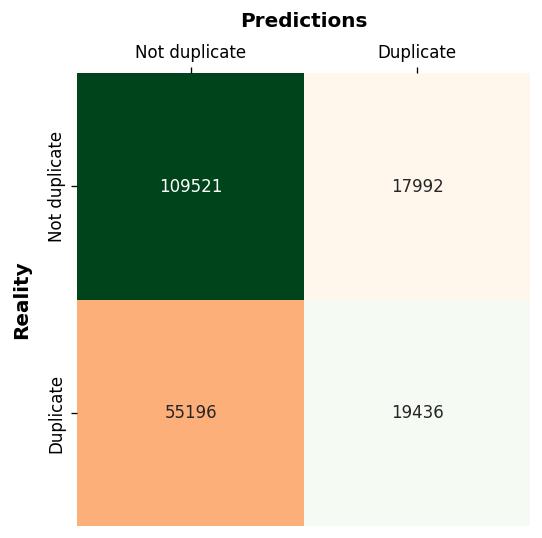

In [11]:
compute_confusion_matrix(y_true=y_true_train, y_pred=y_pred_train, dpi=120)

In [12]:
compute_scores(y_true=y_true_train, y_pred=y_pred_train)

{'Accuracy': '63.79%', 'Recall': '26.04%', 'Precision': '51.93%'}

We obtain:
- an accuracy score that is slightly better than the naïve model (exact match)
- a recall score of **26%** (we still have a lot of **False negatives**)
- a precision score of **52%** (a lot better in terms of **False positives**)

The following cell will allow you to play around with the thresholds. Try to find a good combination that improves your score on the **training dataset**!

Once you think you have a good combination, keep the thresholds values unchanged, and switch to the **test dataset**.

In [13]:
interface = build_rule_configurator(features, targets)

interface.launch(height=800)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x133237f40>, 'http://127.0.0.1:7860/', None)

# Next step

Let's recap:
- We transformed raw text into numeric representations: **feature engineering**
- Then we defined a prediction function that uses the created features and applies thresholds to make a decision: **modeling**

In order to find a correct set of parameter (thresholds), we tested multiple combinations. 

However, we cannot be sure that we found the optimal configuration. 

In the next notebook, we'll see how **Machine Learning** can help in finding a better model !